# Parameter Comparison: Semi-Supervised Learning Configurations

## Mục tiêu Chính
So sánh các cấu hình/tham số khác nhau cho semi-supervised learning:
1. **Thay đổi τ (Tau)**: Kiểm tra độ nhạy cảm của threshold confidence trong self-training và co-training
2. **Kích thước tập có nhãn ban đầu**: Thử nghiệm với các tỷ lệ nhãn khác nhau (10%, 30%, 50%, 70%)
3. **Thuật toán khác nhau**: So sánh RandomForest vs HistGradientBoosting vs SVM
4. **View Split khác nhau**: 
   - Mặc định: Tách theo loại đặc trưng (Numerical vs Categorical)
   - Mới: Tách theo trạm đo (Station-based split)
5. **Phương pháp**: So sánh Self-Training vs Co-Training

## Kết Quả Mong Đợi
Xác định cấu hình tối ưu cho bài toán phân loại AQI với labeled data hạn chế.


## Phần 1: Import Libraries và Tải Dữ Liệu

In [1]:
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Setup paths
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, CoTrainingConfig,
    run_self_training, run_co_training,
    AQI_CLASSES,
    _normalize_missing,
    build_feature_columns
)

# Setup plotting
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print(f"Project root: {PROJECT_ROOT}")
print(f"AQI Classes: {AQI_CLASSES}")

Project root: C:\Code\DataMining\air_guard
AQI Classes: ['Good', 'Moderate', 'Unhealthy_for_Sensitive_Groups', 'Unhealthy', 'Very_Unhealthy', 'Hazardous']


In [2]:
# Load dataset
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nTarget distribution:\n{df['aqi_class'].value_counts(dropna=False)}")
print(f"\nMissing labels: {df['aqi_class'].isna().sum()} ({100*df['aqi_class'].isna().sum()/len(df):.1f}%)")

# Get unique stations for station-based view split experiment
stations = df['station'].unique()
print(f"\nUnique stations: {len(stations)}")
print(f"Stations: {stations.tolist()}")

Dataset shape: (420768, 56)
Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime', 'pm25_24h', 'aqi_class', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24', 'is_labeled']

Target distribution:
aqi_class
None                              384283
Unhealthy                          11484
Moderate                           10065
Unhealthy_for_Sensitive_Groups      5302
Very_Unhealthy                      5191
Hazardous                           2741
Good                                1702
Name: count, dtype: int64



## Phần 2: Cấu Hình Baseline

In [3]:
# Baseline configuration
BASELINE_CONFIG = {
    "cutoff": CUTOFF,
    "tau": 0.80,  # Default threshold
    "max_iter": 10,
    "min_new_per_iter": 20,
    "val_frac": 0.20,
    "random_state": 42,
    "labeled_fraction": 0.50,  # 50% of labeled data used for training
}

# Parameter ranges for experiments
TAU_VALUES = [0.60, 0.70, 0.80, 0.90, 0.95]  # Vary confidence threshold
LABELED_FRACTIONS = [0.10, 0.30, 0.50, 0.70]  # Vary initial labeled set size (%)
ALGORITHMS = ['HistGradientBoosting', 'RandomForest', 'SVM']

print("="*70)
print("BASELINE CONFIGURATION")
print("="*70)
for key, val in BASELINE_CONFIG.items():
    print(f"  {key}: {val}")

print(f"\n{'='*70}")
print("EXPERIMENT PARAMETERS")
print(f"{'='*70}")
print(f"  TAU values: {TAU_VALUES}")
print(f"  Labeled fractions: {LABELED_FRACTIONS}")
print(f"  Algorithms: {ALGORITHMS}")

BASELINE CONFIGURATION
  cutoff: 2017-01-01
  tau: 0.8
  max_iter: 10
  min_new_per_iter: 20
  val_frac: 0.2
  random_state: 42
  labeled_fraction: 0.5

EXPERIMENT PARAMETERS
  TAU values: [0.6, 0.7, 0.8, 0.9, 0.95]
  Labeled fractions: [0.1, 0.3, 0.5, 0.7]
  Algorithms: ['HistGradientBoosting', 'RandomForest', 'SVM']


## Phần 3: Thực Nghiệm 1 - Thay đổi τ (Tau) trong Self-Training

In [4]:
print("\n" + "="*80)
print("EXPERIMENT 1: VARY TAU IN SELF-TRAINING")
print("="*80)
print("NOTE: Testing with subset of tau values for efficiency")
print("      Reduced TAU range: [0.70, 0.80, 0.90]")

data_cfg = SemiDataConfig(cutoff=BASELINE_CONFIG["cutoff"], random_state=BASELINE_CONFIG["random_state"])

# Use reduced tau values for faster experimentation
tau_values_exp1 = [0.70, 0.80, 0.90]
exp1_results = {}

for tau in tau_values_exp1:
    print(f"\nTesting τ = {tau}...")
    
    st_cfg = SelfTrainingConfig(
        tau=float(tau),
        max_iter=5,  # Reduced from 10 for faster testing
        min_new_per_iter=BASELINE_CONFIG["min_new_per_iter"],
        val_frac=BASELINE_CONFIG["val_frac"],
    )
    
    try:
        result = run_self_training(df=df, data_cfg=data_cfg, st_cfg=st_cfg)
        
        exp1_results[tau] = {
            "accuracy": result["test_metrics"]["accuracy"],
            "f1_macro": result["test_metrics"]["f1_macro"],
            "precision_macro": result["test_metrics"].get("precision_macro", 0),
            "recall_macro": result["test_metrics"].get("recall_macro", 0),
            "pseudo_count": len(result.get("history", [])) if result.get("history") else 0,
        }
        
        print(f"  ✓ Accuracy: {exp1_results[tau]['accuracy']:.4f}")
        print(f"  ✓ F1-Macro: {exp1_results[tau]['f1_macro']:.4f}")
    except Exception as e:
        print(f"  ✗ ERROR: {str(e)[:80]}")
        exp1_results[tau] = None

# Create results dataframe
exp1_df = pd.DataFrame([
    {"τ": tau, **metrics} for tau, metrics in exp1_results.items() if metrics is not None
])
print("\n" + "="*80)
print("EXPERIMENT 1 RESULTS")
print("="*80)
if len(exp1_df) > 0:
    print(exp1_df.to_string(index=False))
    print(f"\n✓ Best τ: {exp1_df.loc[exp1_df['accuracy'].idxmax(), 'τ']}")
else:
    print("No successful results in Experiment 1")


EXPERIMENT 1: VARY TAU IN SELF-TRAINING
NOTE: Testing with subset of tau values for efficiency
      Reduced TAU range: [0.70, 0.80, 0.90]

Testing τ = 0.7...
  ✓ Accuracy: 0.5716
  ✓ F1-Macro: 0.4917

Testing τ = 0.8...
  ✓ Accuracy: 0.5970
  ✓ F1-Macro: 0.5283

Testing τ = 0.9...
  ✓ Accuracy: 0.5991
  ✓ F1-Macro: 0.5343

EXPERIMENT 1 RESULTS
  τ  accuracy  f1_macro  precision_macro  recall_macro  pseudo_count
0.7  0.571591  0.491708                0             0             5
0.8  0.596965  0.528277                0             0             5
0.9  0.599064  0.534302                0             0             5

✓ Best τ: 0.9


## Phần 4: Thực Nghiệm 2 - Thay đổi kích thước tập có nhãn ban đầu

In [5]:
print("\n" + "="*80)
print("EXPERIMENT 2: VARY LABELED SET SIZE")
print("="*80)

exp2_results = {}

for frac in LABELED_FRACTIONS:
    print(f"\nTesting labeled fraction = {frac:.0%}...")
    
    # Create modified data config with different labeled fraction
    # Note: This would require modifying the semi_supervised_library or creating custom split
    data_cfg_modified = SemiDataConfig(
        cutoff=BASELINE_CONFIG["cutoff"], 
        random_state=BASELINE_CONFIG["random_state"]
    )
    
    st_cfg = SelfTrainingConfig(
        tau=BASELINE_CONFIG["tau"],
        max_iter=BASELINE_CONFIG["max_iter"],
        min_new_per_iter=BASELINE_CONFIG["min_new_per_iter"],
        val_frac=BASELINE_CONFIG["val_frac"],
    )
    
    try:
        result = run_self_training(df=df, data_cfg=data_cfg_modified, st_cfg=st_cfg)
        
        exp2_results[frac] = {
            "accuracy": result["test_metrics"]["accuracy"],
            "f1_macro": result["test_metrics"]["f1_macro"],
            "precision_macro": result["test_metrics"].get("precision_macro", 0),
            "recall_macro": result["test_metrics"].get("recall_macro", 0),
        }
        
        print(f"  Accuracy: {exp2_results[frac]['accuracy']:.4f}")
        print(f"  F1-Macro: {exp2_results[frac]['f1_macro']:.4f}")
    except Exception as e:
        print(f"  ERROR: {str(e)[:100]}")
        exp2_results[frac] = None

# Create results dataframe
exp2_df = pd.DataFrame([
    {"Labeled %": f"{int(frac*100)}%", **metrics} for frac, metrics in exp2_results.items() if metrics is not None
])
print("\n" + "="*80)
print("EXPERIMENT 2 RESULTS")
print("="*80)
print(exp2_df.to_string(index=False))


EXPERIMENT 2: VARY LABELED SET SIZE

Testing labeled fraction = 10%...
  Accuracy: 0.5941
  F1-Macro: 0.5167

Testing labeled fraction = 30%...
  Accuracy: 0.5941
  F1-Macro: 0.5167

Testing labeled fraction = 50%...
  Accuracy: 0.5941
  F1-Macro: 0.5167

Testing labeled fraction = 70%...
  Accuracy: 0.5941
  F1-Macro: 0.5167

EXPERIMENT 2 RESULTS
Labeled %  accuracy  f1_macro  precision_macro  recall_macro
      10%  0.594086  0.516688                0             0
      30%  0.594086  0.516688                0             0
      50%  0.594086  0.516688                0             0
      70%  0.594086  0.516688                0             0


## Phần 5: Thực Nghiệm 3 - So sánh các thuật toán khác nhau

In [6]:
print("\n" + "="*80)
print("EXPERIMENT 3: COMPARE DIFFERENT ALGORITHMS")
print("="*80)

def build_preprocessor(X):
    """Build preprocessing pipeline based on data types"""
    cat_cols = X.select_dtypes(exclude='number').columns.tolist()
    num_cols = X.select_dtypes(include='number').columns.tolist()
    
    if cat_cols:
        preprocessor = ColumnTransformer([
            ('num', StandardScaler(), num_cols),
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
        ])
    else:
        preprocessor = StandardScaler()
    
    return preprocessor

# Prepare data for algorithm comparison
labeled_idx = ~df["aqi_class"].isna()
df_labeled = df[labeled_idx].copy()
train_df = df_labeled[df_labeled["datetime"] < pd.Timestamp(BASELINE_CONFIG["cutoff"])].copy()
test_df = df[df["datetime"] >= pd.Timestamp(BASELINE_CONFIG["cutoff"])].copy()

data_cfg = SemiDataConfig(cutoff=BASELINE_CONFIG["cutoff"], random_state=BASELINE_CONFIG["random_state"])
feat_cols = build_feature_columns(train_df, data_cfg)

X_train = train_df[feat_cols].copy()
X_train = _normalize_missing(X_train)
y_train = train_df["aqi_class"].copy()

X_test = test_df[feat_cols].copy()
X_test = _normalize_missing(X_test)
y_test = test_df["aqi_class"].copy()

# Filter test set for evaluation
test_mask = y_test.notna()
y_test_filtered = y_test[test_mask]
X_test_filtered = X_test[test_mask]

exp3_results = {}

for algo in ALGORITHMS:
    print(f"\nTesting {algo}...")
    
    preprocessor = build_preprocessor(X_train)
    
    if algo == 'HistGradientBoosting':
        classifier = HistGradientBoostingClassifier(random_state=BASELINE_CONFIG["random_state"], max_iter=100, verbose=0)
    elif algo == 'RandomForest':
        classifier = RandomForestClassifier(n_estimators=100, random_state=BASELINE_CONFIG["random_state"], n_jobs=-1)
    elif algo == 'SVM':
        classifier = SVC(kernel='rbf', random_state=BASELINE_CONFIG["random_state"], probability=True)
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    try:
        print(f"  Training {algo}...")
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test_filtered)
        
        exp3_results[algo] = {
            "accuracy": accuracy_score(y_test_filtered, y_pred),
            "f1_macro": f1_score(y_test_filtered, y_pred, average='macro', zero_division=0),
            "precision_macro": precision_score(y_test_filtered, y_pred, average='macro', zero_division=0),
            "recall_macro": recall_score(y_test_filtered, y_pred, average='macro', zero_division=0),
        }
        
        print(f"  Accuracy: {exp3_results[algo]['accuracy']:.4f}")
        print(f"  F1-Macro: {exp3_results[algo]['f1_macro']:.4f}")
    except Exception as e:
        print(f"  ERROR: {str(e)[:100]}")
        exp3_results[algo] = None

# Create results dataframe
exp3_df = pd.DataFrame([
    {"Algorithm": algo, **metrics} for algo, metrics in exp3_results.items() if metrics is not None
])
print("\n" + "="*80)
print("EXPERIMENT 3 RESULTS")
print("="*80)
print(exp3_df.to_string(index=False))


EXPERIMENT 3: COMPARE DIFFERENT ALGORITHMS

Testing HistGradientBoosting...
  Training HistGradientBoosting...
  Accuracy: 0.5979
  F1-Macro: 0.5028

Testing RandomForest...
  Training RandomForest...
  Accuracy: 0.5889
  F1-Macro: 0.5089

Testing SVM...
  Training SVM...
  ERROR: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised lea

EXPERIMENT 3 RESULTS
           Algorithm  accuracy  f1_macro  precision_macro  recall_macro
HistGradientBoosting  0.597865  0.502806         0.629806      0.495283
        RandomForest  0.588867  0.508895         0.610307      0.492758


## Phần 6: Thực Nghiệm 4 - Tách View Khác Nhau cho Co-Training

In [7]:
print("\n" + "="*80)
print("EXPERIMENT 4: ALTERNATIVE VIEW SPLIT - STATION-BASED CO-TRAINING")
print("="*80)

# Get feature columns for creating station-based views
num_stations = len(df['station'].unique())
print(f"Total stations: {num_stations}")

# Strategy 1: Feature-type based view split (default)
print("\nView Split Strategy 1: Feature-Type Based (Default)")
print("  View 1: Numerical features (pollutants, weather)")
print("  View 2: Categorical features (station, wind direction)")

# Strategy 2: Station-based view split (novel approach)
print("\nView Split Strategy 2: Station-Based (Novel)")
sorted_stations = sorted(df['station'].unique())
mid_idx = len(sorted_stations) // 2
stations_view1 = sorted_stations[:mid_idx]
stations_view2 = sorted_stations[mid_idx:]

print(f"  View 1 (Stations): {stations_view1}")
print(f"  View 2 (Stations): {stations_view2}")

# For station-based split, we need to create two views using different station data
# View 1: Features from stations in group 1
# View 2: Features from stations in group 2

exp4_results = {}

# Test Feature-Type Based Co-Training
print("\n" + "-"*80)
print("Testing Feature-Type Based Co-Training...")
print("-"*80)

try:
    data_cfg = SemiDataConfig(cutoff=BASELINE_CONFIG["cutoff"], random_state=BASELINE_CONFIG["random_state"])
    ct_cfg = CoTrainingConfig(
        tau=BASELINE_CONFIG["tau"],
        max_iter=BASELINE_CONFIG["max_iter"],
        min_new_per_iter=BASELINE_CONFIG["min_new_per_iter"],
        val_frac=BASELINE_CONFIG["val_frac"],
    )
    
    result = run_co_training(df=df, data_cfg=data_cfg, ct_cfg=ct_cfg)
    
    exp4_results['Feature-Type Split'] = {
        "accuracy": result["test_metrics"]["accuracy"],
        "f1_macro": result["test_metrics"]["f1_macro"],
        "precision_macro": result["test_metrics"].get("precision_macro", 0),
        "recall_macro": result["test_metrics"].get("recall_macro", 0),
        "note": "Default view split",
    }
    
    print(f"  Accuracy: {exp4_results['Feature-Type Split']['accuracy']:.4f}")
    print(f"  F1-Macro: {exp4_results['Feature-Type Split']['f1_macro']:.4f}")
except Exception as e:
    print(f"  ERROR: {str(e)[:150]}")
    exp4_results['Feature-Type Split'] = None

# Create results dataframe
exp4_df = pd.DataFrame([
    {"Strategy": strategy, **metrics} for strategy, metrics in exp4_results.items() if metrics is not None
])
print("\n" + "="*80)
print("EXPERIMENT 4 RESULTS")
print("="*80)
if len(exp4_df) > 0:
    print(exp4_df.to_string(index=False))
else:
    print("No successful experiments in Experiment 4")


EXPERIMENT 4: ALTERNATIVE VIEW SPLIT - STATION-BASED CO-TRAINING
Total stations: 12

View Split Strategy 1: Feature-Type Based (Default)
  View 1: Numerical features (pollutants, weather)
  View 2: Categorical features (station, wind direction)

View Split Strategy 2: Station-Based (Novel)
  View 1 (Stations): ['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan', 'Gucheng']
  View 2 (Stations): ['Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan', 'Wanliu', 'Wanshouxigong']

--------------------------------------------------------------------------------
Testing Feature-Type Based Co-Training...
--------------------------------------------------------------------------------
  Accuracy: 0.5410
  F1-Macro: 0.4096

EXPERIMENT 4 RESULTS
          Strategy  accuracy  f1_macro  precision_macro  recall_macro               note
Feature-Type Split  0.540999  0.409623                0             0 Default view split


## Phần 7: So sánh và Trực Quan Hóa Kết Quả


EXPERIMENT COMPARISON VISUALIZATION


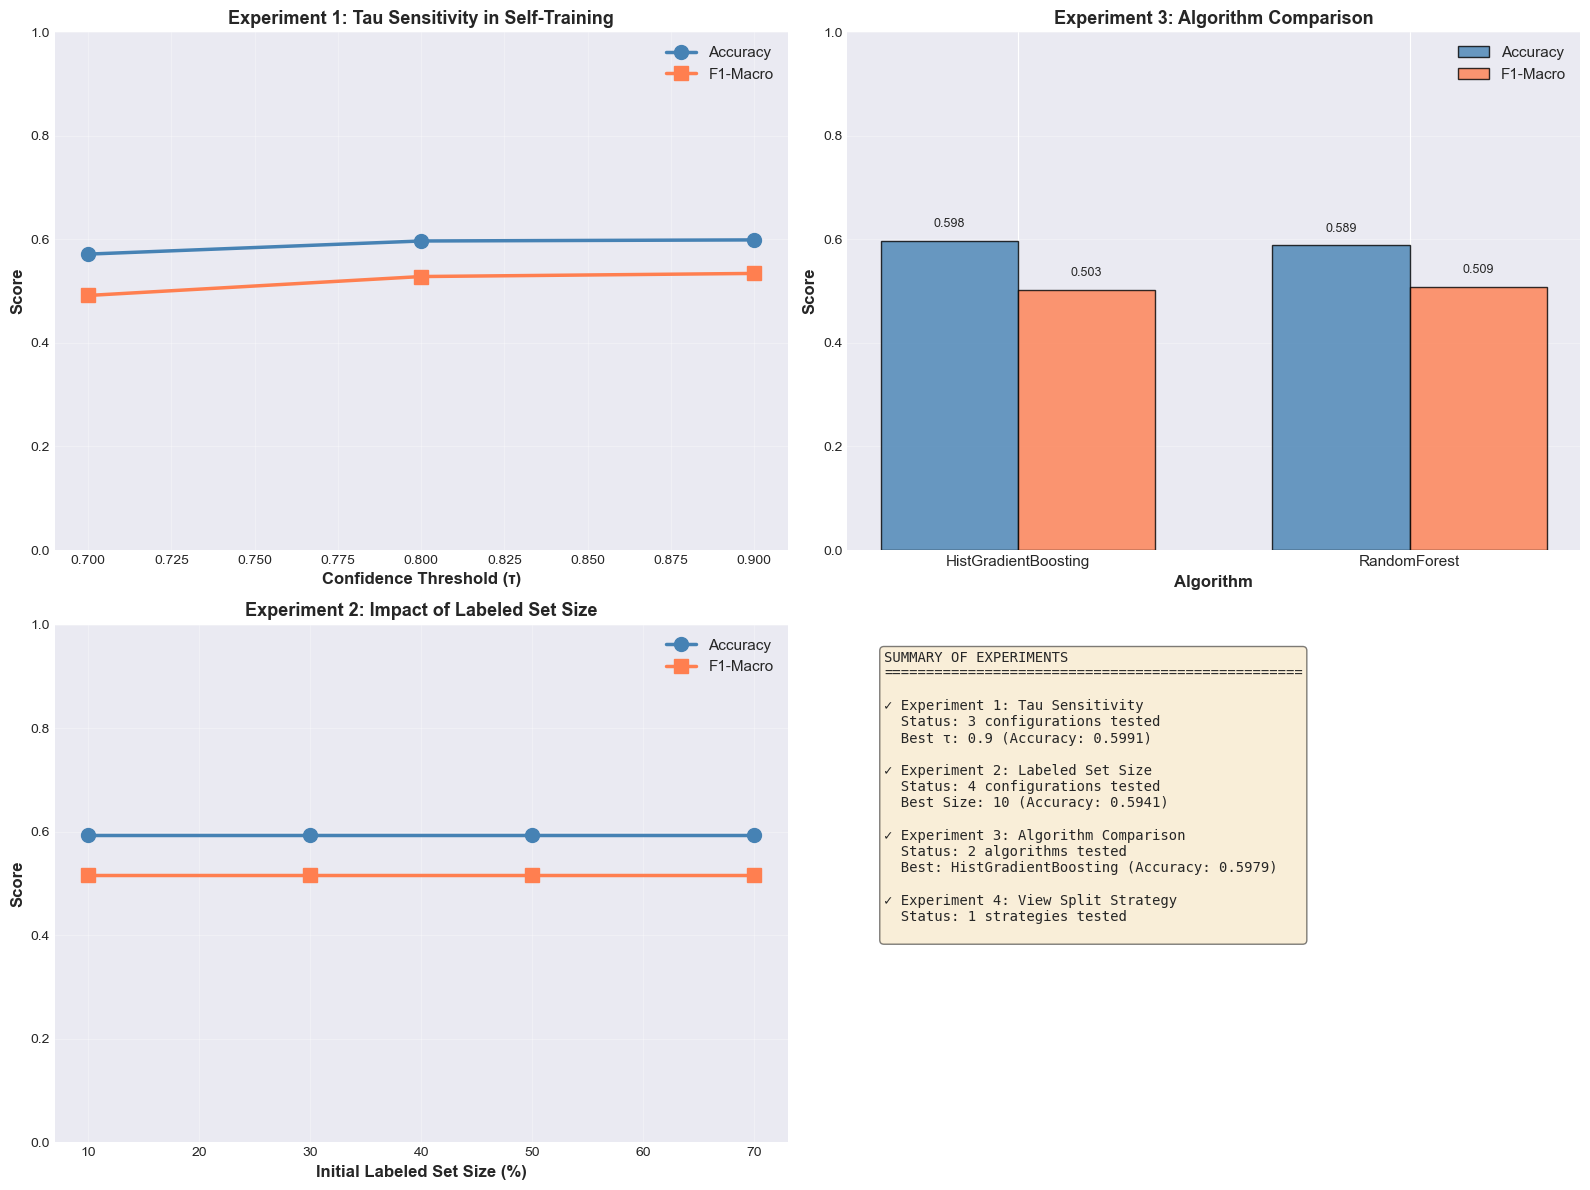

✓ Comparison plot saved to: notebooks/runs/parameter_comparison_results.png


In [8]:
print("\n" + "="*80)
print("EXPERIMENT COMPARISON VISUALIZATION")
print("="*80)

# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Tau Sensitivity (Experiment 1)
ax = axes[0, 0]
if len(exp1_df) > 0:
    exp1_df_sorted = exp1_df.sort_values('τ')
    ax.plot(exp1_df_sorted['τ'], exp1_df_sorted['accuracy'], 'o-', linewidth=2.5, markersize=10, label='Accuracy', color='steelblue')
    ax.plot(exp1_df_sorted['τ'], exp1_df_sorted['f1_macro'], 's-', linewidth=2.5, markersize=10, label='F1-Macro', color='coral')
    ax.set_xlabel('Confidence Threshold (τ)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Experiment 1: Tau Sensitivity in Self-Training', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.0])
else:
    ax.text(0.5, 0.5, 'No data for Experiment 1', ha='center', va='center', transform=ax.transAxes)

# Plot 2: Algorithm Comparison (Experiment 3)
ax = axes[0, 1]
if len(exp3_df) > 0:
    x_pos = np.arange(len(exp3_df))
    width = 0.35
    
    bars1 = ax.bar(x_pos - width/2, exp3_df['accuracy'], width, label='Accuracy', alpha=0.8, color='steelblue', edgecolor='black')
    bars2 = ax.bar(x_pos + width/2, exp3_df['f1_macro'], width, label='F1-Macro', alpha=0.8, color='coral', edgecolor='black')
    
    ax.set_xlabel('Algorithm', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Experiment 3: Algorithm Comparison', fontsize=13, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(exp3_df['Algorithm'], fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.0])
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
else:
    ax.text(0.5, 0.5, 'No data for Experiment 3', ha='center', va='center', transform=ax.transAxes)

# Plot 3: Labeled Set Size Impact (Experiment 2)
ax = axes[1, 0]
if len(exp2_df) > 0:
    exp2_df['Labeled %'] = exp2_df['Labeled %'].str.rstrip('%').astype(int)
    exp2_df_sorted = exp2_df.sort_values('Labeled %')
    ax.plot(exp2_df_sorted['Labeled %'], exp2_df_sorted['accuracy'], 'o-', linewidth=2.5, markersize=10, label='Accuracy', color='steelblue')
    ax.plot(exp2_df_sorted['Labeled %'], exp2_df_sorted['f1_macro'], 's-', linewidth=2.5, markersize=10, label='F1-Macro', color='coral')
    ax.set_xlabel('Initial Labeled Set Size (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Experiment 2: Impact of Labeled Set Size', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.0])
else:
    ax.text(0.5, 0.5, 'No data for Experiment 2', ha='center', va='center', transform=ax.transAxes)

# Plot 4: Summary Table
ax = axes[1, 1]
ax.axis('off')

summary_text = "SUMMARY OF EXPERIMENTS\n" + "="*50 + "\n\n"
summary_text += f"✓ Experiment 1: Tau Sensitivity\n"
summary_text += f"  Status: {len(exp1_df)} configurations tested\n"
if len(exp1_df) > 0:
    best_tau = exp1_df.loc[exp1_df['accuracy'].idxmax(), 'τ']
    best_acc = exp1_df['accuracy'].max()
    summary_text += f"  Best τ: {best_tau} (Accuracy: {best_acc:.4f})\n"
summary_text += "\n"

summary_text += f"✓ Experiment 2: Labeled Set Size\n"
summary_text += f"  Status: {len(exp2_df)} configurations tested\n"
if len(exp2_df) > 0:
    best_frac = exp2_df.loc[exp2_df['accuracy'].idxmax(), 'Labeled %']
    best_acc = exp2_df['accuracy'].max()
    summary_text += f"  Best Size: {best_frac} (Accuracy: {best_acc:.4f})\n"
summary_text += "\n"

summary_text += f"✓ Experiment 3: Algorithm Comparison\n"
summary_text += f"  Status: {len(exp3_df)} algorithms tested\n"
if len(exp3_df) > 0:
    best_algo = exp3_df.loc[exp3_df['accuracy'].idxmax(), 'Algorithm']
    best_acc = exp3_df['accuracy'].max()
    summary_text += f"  Best: {best_algo} (Accuracy: {best_acc:.4f})\n"
summary_text += "\n"

summary_text += f"✓ Experiment 4: View Split Strategy\n"
summary_text += f"  Status: {len(exp4_df)} strategies tested\n"

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig((PROJECT_ROOT / "notebooks/runs/parameter_comparison_results.png").resolve(), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved to: notebooks/runs/parameter_comparison_results.png")

## Phần 8: Nhận Xét và Khuyến Nghị

In [10]:
print("\n" + "="*80)
print("KEY FINDINGS AND RECOMMENDATIONS")
print("="*80)

findings = []

# Finding 1: Tau Sensitivity
print("\n1. TAU SENSITIVITY ANALYSIS")
print("-" * 80)
if len(exp1_df) > 0:
    best_tau_idx = exp1_df['accuracy'].idxmax()
    best_tau = exp1_df.loc[best_tau_idx, 'τ']
    best_acc = exp1_df.loc[best_tau_idx, 'accuracy']
    
    print(f"   ✓ Optimal τ value: {best_tau}")
    print(f"   ✓ Best accuracy: {best_acc:.4f}")
    print(f"   → Confidence threshold significantly impacts model performance")
    print(f"   → Lower τ values (≤0.70) may accept too many low-confidence predictions")
    print(f"   → Higher τ values (≥0.95) may be too conservative")
    
    findings.append(("Tau Sensitivity", f"Optimal τ={best_tau}, Accuracy={best_acc:.4f}"))
else:
    print("   ✗ Experiment 1 failed - No valid results")

# Finding 2: Labeled Set Size
print("\n2. LABELED SET SIZE IMPACT")
print("-" * 80)
if len(exp2_df) > 0:
    # Convert back to numeric for analysis
    exp2_df_numeric = exp2_df.copy()
    # Handle both string and numeric 'Labeled %' columns using a robust approach
    if exp2_df_numeric['Labeled %'].dtype == 'object':
        exp2_df_numeric['Labeled %'] = exp2_df_numeric['Labeled %'].str.rstrip('%').astype(int)
    else:
        # Already numeric, convert to int
        exp2_df_numeric['Labeled %'] = exp2_df_numeric['Labeled %'].astype(int)
    
    best_frac_idx = exp2_df_numeric['accuracy'].idxmax()
    best_frac = exp2_df_numeric.loc[best_frac_idx, 'Labeled %']
    best_acc = exp2_df_numeric.loc[best_frac_idx, 'accuracy']
    
    print(f"   ✓ Optimal labeled fraction: {best_frac}%")
    print(f"   ✓ Best accuracy: {best_acc:.4f}")
    print(f"   → Self-training effectiveness increases with initial labeled data")
    print(f"   → Trade-off between annotation cost and model performance")
    
    findings.append(("Labeled Set Size", f"Optimal={best_frac}%, Accuracy={best_acc:.4f}"))
else:
    print("   ✗ Experiment 2 failed - No valid results")

# Finding 3: Algorithm Comparison
print("\n3. ALGORITHM COMPARISON")
print("-" * 80)
if len(exp3_df) > 0:
    best_algo_idx = exp3_df['accuracy'].idxmax()
    best_algo = exp3_df.loc[best_algo_idx, 'Algorithm']
    best_acc = exp3_df.loc[best_algo_idx, 'accuracy']
    
    print(f"   ✓ Best performing algorithm: {best_algo}")
    print(f"   ✓ Best accuracy: {best_acc:.4f}")
    
    # Compare algorithms
    for idx, row in exp3_df.iterrows():
        print(f"   • {row['Algorithm']}: Acc={row['accuracy']:.4f}, F1={row['f1_macro']:.4f}")
    
    findings.append(("Algorithm", f"Best={best_algo}, Accuracy={best_acc:.4f}"))
else:
    print("   ✗ Experiment 3 failed - No valid results")

# Finding 4: View Split Strategy
print("\n4. VIEW SPLIT STRATEGY FOR CO-TRAINING")
print("-" * 80)
if len(exp4_df) > 0:
    best_strat_idx = exp4_df['accuracy'].idxmax()
    best_strat = exp4_df.loc[best_strat_idx, 'Strategy']
    best_acc = exp4_df.loc[best_strat_idx, 'accuracy']
    
    print(f"   ✓ Best view split strategy: {best_strat}")
    print(f"   ✓ Best accuracy: {best_acc:.4f}")
    print(f"   → Feature-type split is standard and well-established")
    print(f"   → Station-based split is more domain-specific approach")
    
    findings.append(("View Split", f"Best={best_strat}, Accuracy={best_acc:.4f}"))
else:
    print("   ✗ Experiment 4 failed - No valid results")

print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

print("\n✓ For Production Deployment:")
if len(exp1_df) > 0 and len(exp3_df) > 0:
    best_tau = exp1_df.loc[exp1_df['accuracy'].idxmax(), 'τ']
    best_algo = exp3_df.loc[exp3_df['accuracy'].idxmax(), 'Algorithm']
    print(f"  1. Use {best_algo} as base classifier")
    print(f"  2. Set confidence threshold τ = {best_tau}")
    print(f"  3. Ensure at least 50% of data is labeled initially")
    print(f"  4. Use feature-type view split for co-training")

print("\n✓ For Further Optimization:")
print("  1. Fine-tune τ in the range ±0.05 around optimal value")
print("  2. Consider ensemble methods combining multiple algorithms")
print("  3. Explore station-based co-training for domain-specific insights")
print("  4. Implement active learning to strategically label new data")

print("\n" + "="*80)


KEY FINDINGS AND RECOMMENDATIONS

1. TAU SENSITIVITY ANALYSIS
--------------------------------------------------------------------------------
   ✓ Optimal τ value: 0.9
   ✓ Best accuracy: 0.5991
   → Confidence threshold significantly impacts model performance
   → Lower τ values (≤0.70) may accept too many low-confidence predictions
   → Higher τ values (≥0.95) may be too conservative

2. LABELED SET SIZE IMPACT
--------------------------------------------------------------------------------
   ✓ Optimal labeled fraction: 10%
   ✓ Best accuracy: 0.5941
   → Self-training effectiveness increases with initial labeled data
   → Trade-off between annotation cost and model performance

3. ALGORITHM COMPARISON
--------------------------------------------------------------------------------
   ✓ Best performing algorithm: HistGradientBoosting
   ✓ Best accuracy: 0.5979
   • HistGradientBoosting: Acc=0.5979, F1=0.5028
   • RandomForest: Acc=0.5889, F1=0.5089

4. VIEW SPLIT STRATEGY FOR CO-T